In [1]:
import sys, os, math
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import torch
import espaloma as esp

from openff.toolkit.topology import Molecule

In [2]:
# grab data
if not os.path.exists("phalkethoh_mm_small.zip"):
    os.system("wget http://data.wangyq.net/esp_dataset/phalkethoh_mm_small.zip")
    print("file downloaded")

In [3]:
#%%capture
#!unzip phalkethoh_mm_small.zip

In [5]:
ds = esp.data.dataset.GraphDataset.load("phalkethoh")
ds.shuffle(seed=2666)
ds_tr, ds_vl, ds_te = ds.split([8, 1, 1])

In [6]:
# load training dataloader with batch size=100
ds_tr_loader = ds_tr.view(batch_size=100, shuffle=True)

g_tr = next(iter(ds_tr.view(batch_size=len(ds_tr))))
g_vl = next(iter(ds_vl.view(batch_size=len(ds_vl))))

## espaloma training

#### stage 1: graph -> atom latent representation

In [7]:
representation = esp.nn.Sequential(
    layer=esp.nn.layers.dgl_legacy.gn("SAGEConv"), # use SAGEConv implementation in DGL
    config=[128, "relu", 128, "relu", 128, "relu"], # 3 layers, 128 units, ReLU activation
)

#### stage 2 and 3: atom latent representation bond, angle, and torsion representation and parameters

In [8]:
readout = esp.nn.readout.janossy.JanossyPooling(
    in_features=128, config=[128, "relu", 128, "relu", 128, "relu"],
    out_features={              # define modular MM parameters Espaloma will assign
        1: {"e": 1, "s": 1}, # atom hardness and electronegativity
        2: {"log_coefficients": 2}, # bond linear combination, enforce positive
        3: {"log_coefficients": 2}, # angle linear combination, enforce positive
        4: {"k": 6}, # torsion barrier heights (can be positive or negative)
    },
)

#### compose all three stages Espaloma stages into an end-to-end model

In [9]:
espaloma_model = torch.nn.Sequential(
    representation, readout, esp.nn.readout.janossy.ExpCoefficients(),
    esp.mm.geometry.GeometryInGraph(),
    esp.mm.energy.EnergyInGraph(),
    esp.mm.energy.EnergyInGraph(suffix="_ref"),
    esp.nn.readout.charge_equilibrium.ChargeEquilibrium(),
)

In [10]:
if torch.cuda.is_available():
    espaloma_model = espaloma_model.cuda()
else:
    print("cuda not available")

cuda not available


In [11]:
# define loss function (MSE between predicted and reference energy)
loss_fn = esp.metrics.GraphMetric(
    base_metric=torch.nn.MSELoss(), # use mean-squared error loss
    between=['u', "u_ref"],         # between predicted and QM energies
    level="g", # compare on graph level
)

In [12]:
# define optimizer
optimizer = torch.optim.Adam(espaloma_model.parameters(), 1e-4)

## train model

In [13]:
#n_epochs = 10000
n_epochs = 10

In [14]:
for idx_epoch in range(n_epochs):
    for g in ds_tr_loader:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            g = g.to("cuda:0")
        g = espaloma_model(g)
        loss = loss_fn(g)
        loss.backward()
        optimizer.step()
        torch.save(espaloma_model.state_dict(), "%s.th" % idx_epoch)

## inspect loss 

In [16]:
inspect_metric = esp.metrics.GraphMetric(
    base_metric=torch.nn.L1Loss(), # use mean-squared error loss
    between=['u', "u_ref"],         # between predicted and QM energies
    level="g", # compare on graph level
)

In [17]:
if torch.cuda.is_available():
    g_vl = g_vl.to("cuda:0")
    g_tr = g_tr.to("cuda:0")

In [18]:
loss_tr = []
loss_vl = []

In [19]:
for idx_epoch in range(n_epochs):
    espaloma_model.load_state_dict(
        torch.load("%s.th" % idx_epoch)
    )

    espaloma_model(g_tr)
    loss_tr.append(inspect_metric(g_tr).item())

    espaloma_model(g_vl)
    loss_vl.append(inspect_metric(g_vl).item())

In [20]:
loss_tr = np.array(loss_tr) * 627.5
loss_vl = np.array(loss_vl) * 627.5

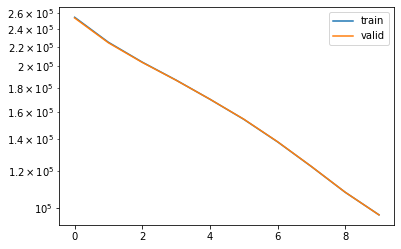

In [23]:
from matplotlib import pyplot as plt

plt.plot(loss_tr, label="train")
plt.plot(loss_vl, label="valid")
plt.yscale("log")
plt.legend()
plt.show()